# Caltech UCSD Birds 200 2011 (CUB-200-2011)

## Part 5B - Extracting the output layer activations.

The previous notebooks showed how to train a ResNet 152 model which had been initialised with pre-trained weights from ImageNet, for the task of fine grained image classification of bird species using the CUB-200-2011 dataset, and evaluate its performance by investigating the class accuracy of each class of birds. We then extracted the activations from the final layer before the classification layer.

This notebook shows how to use these extracted activations of the final layer of the model to investigate what the model has learnt about the input image set used to train it. We achieve this through a mathetical transform, that allows us to take this very large and cumbersome dataset, which contains many degrees of freedom, and reduce it down to a 2D dimensional representation. That way, as humans, we can plot the resulting transformation and use to infer how our model is performing.

This is the fifth stage of our roadmap for building and understanding a birds image classifier:

![RoadMapImage](../docs/birds_roadmap.png)

This notebook will show in detail:

    1. Reducing the number dimensions (columns) in the activations dataset.
    
    2. Perform a transformation that reduces our dataset down to 2D for plotting (manifold learning).
    
    3. Plotting of 2D transformed results in static and dynamic plots to aid in interpretation.

## Notebook setup

### Modules and externals

In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models

#from imutils import paths
from pathlib import Path
import os, sys
import time
import copy

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Local modules
from cub_tools.train import train_model
from cub_tools.visualize import imshow, visualize_model
from cub_tools.utils import unpickle, save_pickle
from cub_tools.transforms import makeDefaultTransforms

### Runtime setup

In [3]:
# Script runtime options
root_dir = '..' # '/home/jupyter/caltech_birds'
model = 'resnet152'
data_root_dir = os.path.join(root_dir, 'data')
model_root_dir = os.path.join(root_dir, 'models')
stages = ['test']


# Paths setup
data_dir = os.path.join(data_root_dir,'images')
output_dir = os.path.join(model_root_dir,'classification/{}'.format(model))
model_history = os.path.join(output_dir,'model_history.pkl')
model_file = os.path.join(output_dir, 'caltech_birds_{}_full.pth'.format(model))

In [4]:
# Get data transforms
data_transforms = makeDefaultTransforms()

In [5]:
# Setup data loaders with augmentation transforms
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in stages}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1,
                                             shuffle=True, num_workers=4)
              for x in stages}
dataset_sizes = {x: len(image_datasets[x]) for x in stages}
class_names = image_datasets[stages[0]].classes

In [6]:
# Load the extracted feature maps
feature_maps_dict = unpickle(os.path.join(output_dir,'resnet152_feature_extractions.pkl'))
features = np.array(feature_maps_dict['feature extractions']).squeeze()

In [7]:
feature_maps_dict.keys()

dict_keys(['labels truth', 'labels pred', 'image paths', 'feature extractions'])

# Domain Reduction - Principal Components Analysis

## Assess all components

Compute all components to assess the number of components required to reconstruct 95% of the feature map information.

In [8]:
# Domain reduction
from sklearn.decomposition import PCA

In [9]:
pca = PCA()
pca.fit(features)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [10]:
cum_explained_variance_ratio= []
cumsum=0.
for comp in pca.explained_variance_ratio_:
    cumsum += comp
    cum_explained_variance_ratio.append( cumsum )

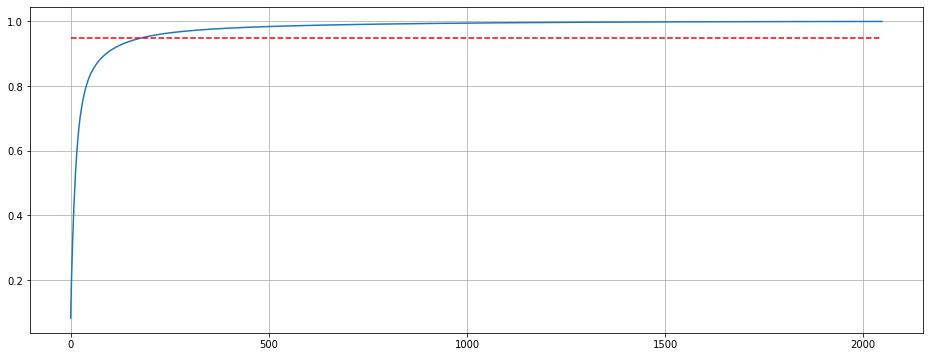

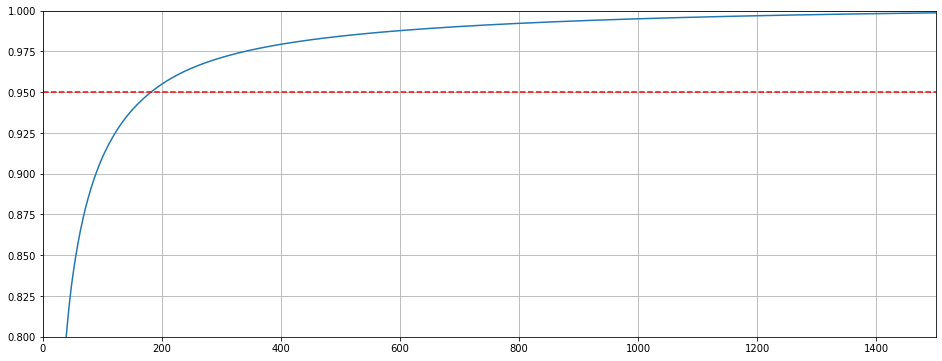

In [11]:
plt.figure(figsize=(16,6))
plt.plot(np.arange(0,len(cum_explained_variance_ratio),1),cum_explained_variance_ratio)
plt.plot([0, len(cum_explained_variance_ratio)], [0.95, 0.95], 'r--')
plt.grid(True)
plt.yscale('linear')
plt.show()

plt.figure(figsize=(16,6))
plt.plot(np.arange(0,len(cum_explained_variance_ratio),1),cum_explained_variance_ratio)
plt.plot([0, len(cum_explained_variance_ratio)], [0.95, 0.95], 'r--')
plt.grid(True)
plt.yscale('linear')
plt.ylim([0.8,1.0])
plt.xlim([0, 1500])
plt.show()

## Compute the PCA transform and apply to the feature maps

200 components was found to recover ~95% of the variance in the data.
This is domain reduction from 2048 to 200 dimensions.

In [12]:
pca = PCA(n_components=200)
pca.fit(features)

PCA(copy=True, iterated_power='auto', n_components=200, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [13]:
pca_features = pca.transform(features)

In [14]:
pca_features.shape

(5794, 200)

In [15]:
pca_features_dict = {'pca_features' : pca_features,
                     'pca_model' : pca,
                     'n_components' : 200,
                     'cumulative explained variance ratio (all components)' : cum_explained_variance_ratio}

In [16]:
save_pickle(pca_features_dict, os.path.join(output_dir,'{}_pca_feature_extractions.pkl'.format(model)))

# Manifold Learning Representations


In [33]:
def get_manifold_df(trf_data, labels_truth, labels_pred, class_names, img_paths):
    
    class_truth = []
    class_pred = []
    for label_truth in labels_truth:
        class_truth.append( class_names[label_truth] )
        
    for label_pred in labels_pred:
        class_pred.append( class_names[label_pred] )
        
    return pd.DataFrame({'Manifold Dim 1' : trf_data[:,0], 
                         'Manifold Dim 2' : trf_data[:,1], 
                         'label (truth)' : labels_truth,
                         'label (pred)' : labels_pred,
                         'class name (truth)' : class_truth,
                         'class name (pred)' : class_pred,
                         'image path' : img_paths})

## t-SNE of image feature maps

In [18]:
from sklearn.manifold import TSNE

In [19]:
tsne = TSNE(n_components=2, learning_rate=150, perplexity=50, angle=0.2, verbose=2).fit_transform(pca_features)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 5794 samples in 0.086s...
[t-SNE] Computed neighbors for 5794 samples in 10.208s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5794
[t-SNE] Computed conditional probabilities for sample 2000 / 5794
[t-SNE] Computed conditional probabilities for sample 3000 / 5794
[t-SNE] Computed conditional probabilities for sample 4000 / 5794
[t-SNE] Computed conditional probabilities for sample 5000 / 5794
[t-SNE] Computed conditional probabilities for sample 5794 / 5794
[t-SNE] Mean sigma: 6.256652
[t-SNE] Computed conditional probabilities in 0.572s
[t-SNE] Iteration 50: error = 85.9661484, gradient norm = 0.0033986 (50 iterations in 3.457s)
[t-SNE] Iteration 100: error = 75.2181778, gradient norm = 0.0030175 (50 iterations in 2.807s)
[t-SNE] Iteration 150: error = 74.1150284, gradient norm = 0.0007171 (50 iterations in 2.598s)
[t-SNE] Iteration 200: error = 73.8893127, gradient norm = 0.0002318 (50 iterations in 2.530s)


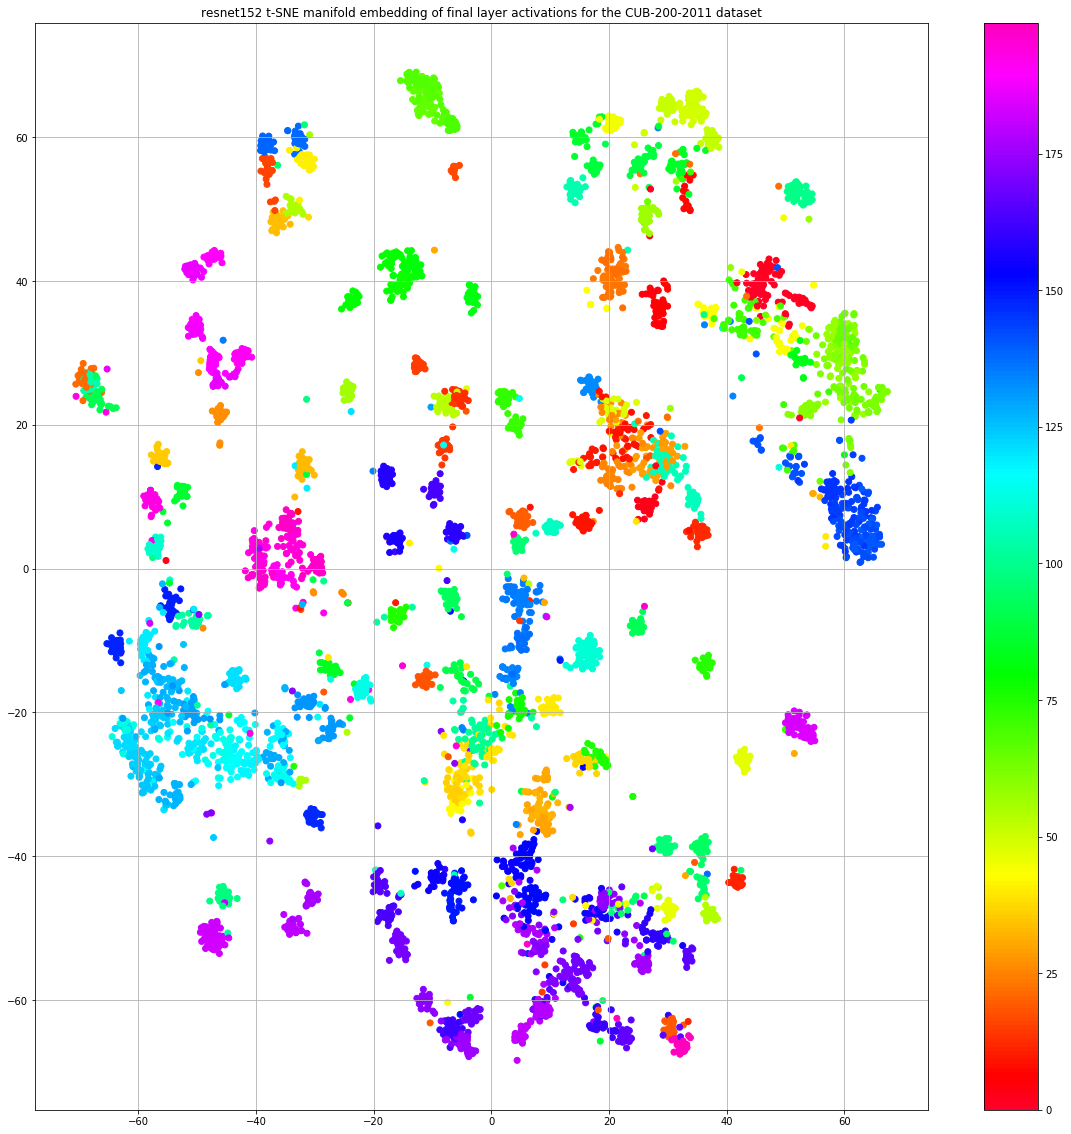

In [20]:
plt.figure(figsize=(20,20))
plt.scatter(tsne[:,0], tsne[:,1], c=feature_maps_dict['labels truth'], cmap='gist_rainbow')
plt.colorbar()
plt.grid(True)
plt.title(model+' t-SNE manifold embedding of final layer activations for the CUB-200-2011 dataset')
plt.show()

In [64]:
tsne_df_bak = get_manifold_df(trf_data=tsne, 
                          labels_truth=feature_maps_dict['labels truth'],
                          labels_pred=feature_maps_dict['labels pred'],
                          class_names=class_names, 
                          img_paths=feature_maps_dict['image paths'])

In [65]:
tsne_df_bak

Manifold Dim 1  Manifold Dim 2  label (truth)  label (pred)  \
0          35.827240      -38.459656             94            94   
1          30.138483       55.582851             85            85   
2         -37.254261       55.357491             16            16   
3          35.348965        5.431987             12            12   
4         -22.807396      -16.620558            113           113   
...              ...             ...            ...           ...   
5789       17.261126      -10.679007            111           111   
5790      -31.387266      -43.815727            177           147   
5791       58.010338        8.245843            144           144   
5792      -36.903664      -28.663033            115           115   
5793       24.953337       20.503794             22             8   

              class name (truth)           class name (pred)  \
0           095.Baltimore_Oriole        095.Baltimore_Oriole   
1               086.Pacific_Loon            086.Pacific_Loon   
2                   017.Cardinal                017.Cardinal   
3                   013.Bobolink                013.Bobolink   
4     114.Black_throated_Sparrow  114.Black_throated_Sparrow   
...                          ...                         ...   
5789       112.Great_Grey_Shrike       112.Great_Grey_Shrike   
5790        178.Swainson_Warbler     148.Green_tailed_Towhee   
5791            145.Elegant_Tern            145.Elegant_Tern   
5792        116.Chipping_Sparrow        116.Chipping_Sparrow   
5793        023.Brandt_Cormorant        009.Brewer_Blackbird   

                                             image path  
0     ../data/images/test/095.Baltimore_Oriole/Balti...  
1     ../data/images/test/086.Pacific_Loon/Pacific_L...  
2     ../data/images/test/017.Cardinal/Cardinal_0093...  
3     ../data/images/test/013.Bobolink/Bobolink_0114...  
4     ../data/images/test/114.Black_throated_Sparrow...  
...                                                 ...  
5789  ../data/images/test/112.Great_Grey_Shrike/Grea...  
5790  ../data/images/test/178.Swainson_Warbler/Swain...  
5791  ../data/images/test/145.Elegant_Tern/Elegant_T...  
5792  ../data/images/test/116.Chipping_Sparrow/Chipp...  
5793  ../data/images/test/023.Brandt_Cormorant/Brand...  

[5794 rows x 7 columns]

In [66]:
from PIL import Image, ImageDraw, ImageFont
import io
import base64
import numpy
from skimage.util import img_as_uint, img_as_ubyte
from skimage.io import imsave

In [67]:
img_scale_factor = 0.5

In [68]:
def encode_image(im):
    rawBytes = io.BytesIO()    
    im = Image.fromarray(img_as_ubyte(np.array(im)))
    im.save(rawBytes, "PNG")
    rawBytes.seek(0) 
    encoded_image = base64.b64encode(rawBytes.read()).decode()
    return f'data:image/png;base64,{encoded_image}'

def add_class_to_image(im, classname, textfill=(255,255,255,255), textsize=0.75, textpos=(10,10)):
    # Add the class name to the image
    txt = Image.new('RGBA', (int(im.size[0]*textsize),int(im.size[1]*textsize)), (255,255,255,0))
    d = ImageDraw.Draw(txt)
    font = ImageFont.load_default()
    d.text(textpos, classname, font=font, fill=textfill)
    return Image.alpha_composite(im.convert('RGBA'), txt.resize(im.size))

In [51]:
run_encoding = False
if run_encoding:
    print('[INFO] Encoding images (100):', end='')
    encoded_images = []
    encoded_thumbs = []
    for i, image in enumerate(tsne_df['image path']):
        if (i % 100==0):
            print('|',end='')
        if (i % 1000==0):
            print('{}'.format(i),end='')
        im =  Image.open(image)
        im = add_class_to_image(im, tsne_df['class name (truth)'].iloc[i])
        encoded_image.append(encode_image(im))
        encoded_thumbs.append(encode_image(im.resize((int(im.size[0]*img_scale_factor), int(im.size[1]*img_scale_factor)), resample=3)))
    print(':')
    tsne_df['encoded image'] = encoded_images
    tsne_df['encoded image thumbs'] = encoded_thumbs
    tsne_df.to_pickle(os.path.join(output_dir,'{}_tsne_feature_extractions.pkl'.format(model)))
else:
    tsne_df = pd.read_pickle(os.path.join(output_dir,'{}_tsne_feature_extractions.pkl'.format(model)))

In [71]:
tsne_df['label (pred)'] = tsne_df_bak['label (pred)']
tsne_df['class name (pred)'] = tsne_df_bak['class name (pred)'] 
tsne_df.to_pickle(os.path.join(output_dir,'{}_tsne_feature_extractions.pkl'.format(model)))

In [70]:
tsne_df

Manifold Dim 1  Manifold Dim 2  label (truth)  \
0          -2.980398      -52.962040             94   
1          64.719620       15.969509             85   
2          21.956379      -64.955460             16   
3          29.751053        5.794495             12   
4         -27.157417        8.519850            113   
...              ...             ...            ...   
5789       -1.845755        5.936778            111   
5790      -43.146801      -21.351391            177   
5791       22.192770       57.085938            144   
5792      -47.261311        4.475277            115   
5793       42.039761       -6.862700             22   

              class name (truth)  \
0           095.Baltimore_Oriole   
1               086.Pacific_Loon   
2                   017.Cardinal   
3                   013.Bobolink   
4     114.Black_throated_Sparrow   
...                          ...   
5789       112.Great_Grey_Shrike   
5790        178.Swainson_Warbler   
5791            145.Elegant_Tern   
5792        116.Chipping_Sparrow   
5793        023.Brandt_Cormorant   

                                             image path  \
0     ../data/images/test/095.Baltimore_Oriole/Balti...   
1     ../data/images/test/086.Pacific_Loon/Pacific_L...   
2     ../data/images/test/017.Cardinal/Cardinal_0093...   
3     ../data/images/test/013.Bobolink/Bobolink_0114...   
4     ../data/images/test/114.Black_throated_Sparrow...   
...                                                 ...   
5789  ../data/images/test/112.Great_Grey_Shrike/Grea...   
5790  ../data/images/test/178.Swainson_Warbler/Swain...   
5791  ../data/images/test/145.Elegant_Tern/Elegant_T...   
5792  ../data/images/test/116.Chipping_Sparrow/Chipp...   
5793  ../data/images/test/023.Brandt_Cormorant/Brand...   

                                          encoded image  \
0     data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...   
1     data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...   
2     data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...   
3     data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...   
4     data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...   
...                                                 ...   
5789  data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...   
5790  data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...   
5791  data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...   
5792  data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...   
5793  data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...   

                                   encoded image thumbs  label (pred)  \
0     data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...            94   
1     data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...            85   
2     data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...            16   
3     data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...            12   
4     data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...           113   
...                                                 ...           ...   
5789  data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...           111   
5790  data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...           147   
5791  data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...           144   
5792  data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...           115   
5793  data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...             8   

               class name (pred)  
0           095.Baltimore_Oriole  
1               086.Pacific_Loon  
2                   017.Cardinal  
3                   013.Bobolink  
4     114.Black_throated_Sparrow  
...                          ...  
5789       112.Great_Grey_Shrike  
5790     148.Green_tailed_Towhee  
5791            145.Elegant_Tern  
5792        116.Chipping_Sparrow  
5793        009.Brewer_Blackbird  

[5794 rows x 9 columns]

In [72]:
import hvplot.pandas

In [73]:
tsne_df.hvplot.scatter(x='Manifold Dim 1', 
                       y='Manifold Dim 2', 
                       by='label (truth)', 
                       frame_width=1000, 
                       frame_height=1000, 
                       hover_cols=['class name (truth)', 'class name (pred)'], 
                       grid=True, cmap='gist_rainbow')

:NdOverlay   [label (truth)]
   :Scatter   [Manifold Dim 1]   (Manifold Dim 2,class name (truth),class name (pred))

In [ ]:
from bokeh.plotting import ColumnDataSource, figure, output_file, show

min_index = 0
max_index = 4500
x=tsne_df['Manifold Dim 1'][min_index:max_index]
y=tsne_df['Manifold Dim 2'][min_index:max_index]

# get a colormap from matplotlib
colormap = plt.cm.get_cmap("gist_rainbow") #choose any matplotlib colormap here

# define maximum and minimum for cmap
colorspan=[0,200]

# create a color channel with a value between 0 and 1
# outside the colorspan the value becomes 0 (left) and 1 (right)
cmap_input=np.interp(tsne_df['label (truth)'][min_index:max_index],colorspan,[0,1],left=0,right=1)

# use colormap to generate rgb-values
# second value is alfa (not used)
# third parameter gives int if True, otherwise float
A_color=colormap(cmap_input,1,True)

# convert to hex to fit to bokeh
bokeh_colors = ["#%02x%02x%02x" % (r, g, b) for r, g, b in A_color[:,0:3]]

output_file("caltech_birds_resnet152_featuremaps_tsne_embedding.html")

source = ColumnDataSource(data=dict(
    x=x,
    y=y,
    imgs=tsne_df['encoded image thumbs'][min_index:max_index],
    classnames=tsne_df['class name (truth)'][min_index:max_index],
    prediction=tsne_df['class name (pred)'][min_index:max_index],
    colors=bokeh_colors
))

TOOLTIPS = """
    <div>
        <div>
            <img
                src="@imgs" height="100" width="100"
                style="float: left; margin: 0px 15px 15px 0px;"
                border="2"
            ></img>
        </div>
        <div>
            <span style="font-size: 17px; font-weight: bold;">@classnames</span>
            <span style="font-size: 17px; font-weight: bold;">@prediction</span>
            <span style="font-size: 15px; color: #966;">[$index]</span>
        </div>
    </div>
"""

p = figure(plot_width=1200, plot_height=1200, tooltips=TOOLTIPS,
           title="Mouse over the dots")

p.circle('x', 'y',fill_color='colors', line_color=None, size=5, source=source, fill_alpha=0.3, line_alpha=0.3)

show(p)


In [74]:
from matplotlib.pyplot import imshow
from PIL import Image
import random
import rasterfairy

In [75]:
num_images_to_plot = 2500

if len(tsne_df['image path']) > num_images_to_plot:
    sort_order = sorted(random.sample(range(len(tsne_df['image path'])), num_images_to_plot))
    #images = [tsne_df['image path'][i] for i in sort_order]
    tsne_df__plotting = pd.DataFrame([tsne_df.iloc[i] for i in sort_order])
else:
    tsne_df__plotting = tsne_df

In [76]:
images = []
for id, path in zip(tsne_df__plotting.index,tsne_df__plotting['image path']):
    images.append(Image.open(path))
tsne_df__plotting['images'] = images

In [77]:
tsne_df__plotting

Manifold Dim 1  Manifold Dim 2  label (truth)  \
1          64.719620       15.969509             85   
4         -27.157417        8.519850            113   
6         -44.685707      -50.685112            173   
7          41.387596      -39.336384             73   
8          30.734694       48.622360             59   
...              ...             ...            ...   
5781       23.460562      -66.225739             16   
5785      -46.341614      -34.825562            155   
5786       -6.967600      -38.200302             47   
5787       61.415344       19.313427             85   
5788      -45.339443      -49.473248            173   

              class name (truth)  \
1               086.Pacific_Loon   
4     114.Black_throated_Sparrow   
6               174.Palm_Warbler   
7                074.Florida_Jay   
8       060.Glaucous_winged_Gull   
...                          ...   
5781                017.Cardinal   
5785        156.White_eyed_Vireo   
5786      048.European_Goldfinch   
5787            086.Pacific_Loon   
5788            174.Palm_Warbler   

                                             image path  \
1     ../data/images/test/086.Pacific_Loon/Pacific_L...   
4     ../data/images/test/114.Black_throated_Sparrow...   
6     ../data/images/test/174.Palm_Warbler/Palm_Warb...   
7     ../data/images/test/074.Florida_Jay/Florida_Ja...   
8     ../data/images/test/060.Glaucous_winged_Gull/G...   
...                                                 ...   
5781  ../data/images/test/017.Cardinal/Cardinal_0038...   
5785  ../data/images/test/156.White_eyed_Vireo/White...   
5786  ../data/images/test/048.European_Goldfinch/Eur...   
5787  ../data/images/test/086.Pacific_Loon/Pacific_L...   
5788  ../data/images/test/174.Palm_Warbler/Palm_Warb...   

                                          encoded image  \
1     data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...   
4     data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...   
6     data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...   
7     data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...   
8     data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...   
...                                                 ...   
5781  data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...   
5785  data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...   
5786  data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...   
5787  data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...   
5788  data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...   

                                   encoded image thumbs  label (pred)  \
1     data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...            85   
4     data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...           113   
6     data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...           173   
7     data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...            73   
8     data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...            63   
...                                                 ...           ...   
5781  data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...            16   
5785  data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...           155   
5786  data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...            47   
5787  data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...             7   
5788  data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...           173   

               class name (pred)  \
1               086.Pacific_Loon   
4     114.Black_throated_Sparrow   
6               174.Palm_Warbler   
7                074.Florida_Jay   
8           064.Ring_billed_Gull   
...                          ...   
5781                017.Cardinal   
5785        156.White_eyed_Vireo   
5786      048.European_Goldfinch   
5787       008.Rhinoceros_Auklet   
5788            174.Palm_Warbler   

                                                 images  
1     <PIL.JpegImagePlugin.JpegImageFile image mode=...  
4     <PIL.JpegImagePlugin.JpegImageFile image mode=...  
6     <PIL

In [81]:
width = 4000
height = 3000
max_dim = 100

full_image = Image.new('RGBA', (width, height))
for img, x, y in zip(tsne_df__plotting['image path'], tsne_df__plotting['Manifold Dim 1'], tsne_df__plotting['Manifold Dim 2']):
    tile = Image.open(img)
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

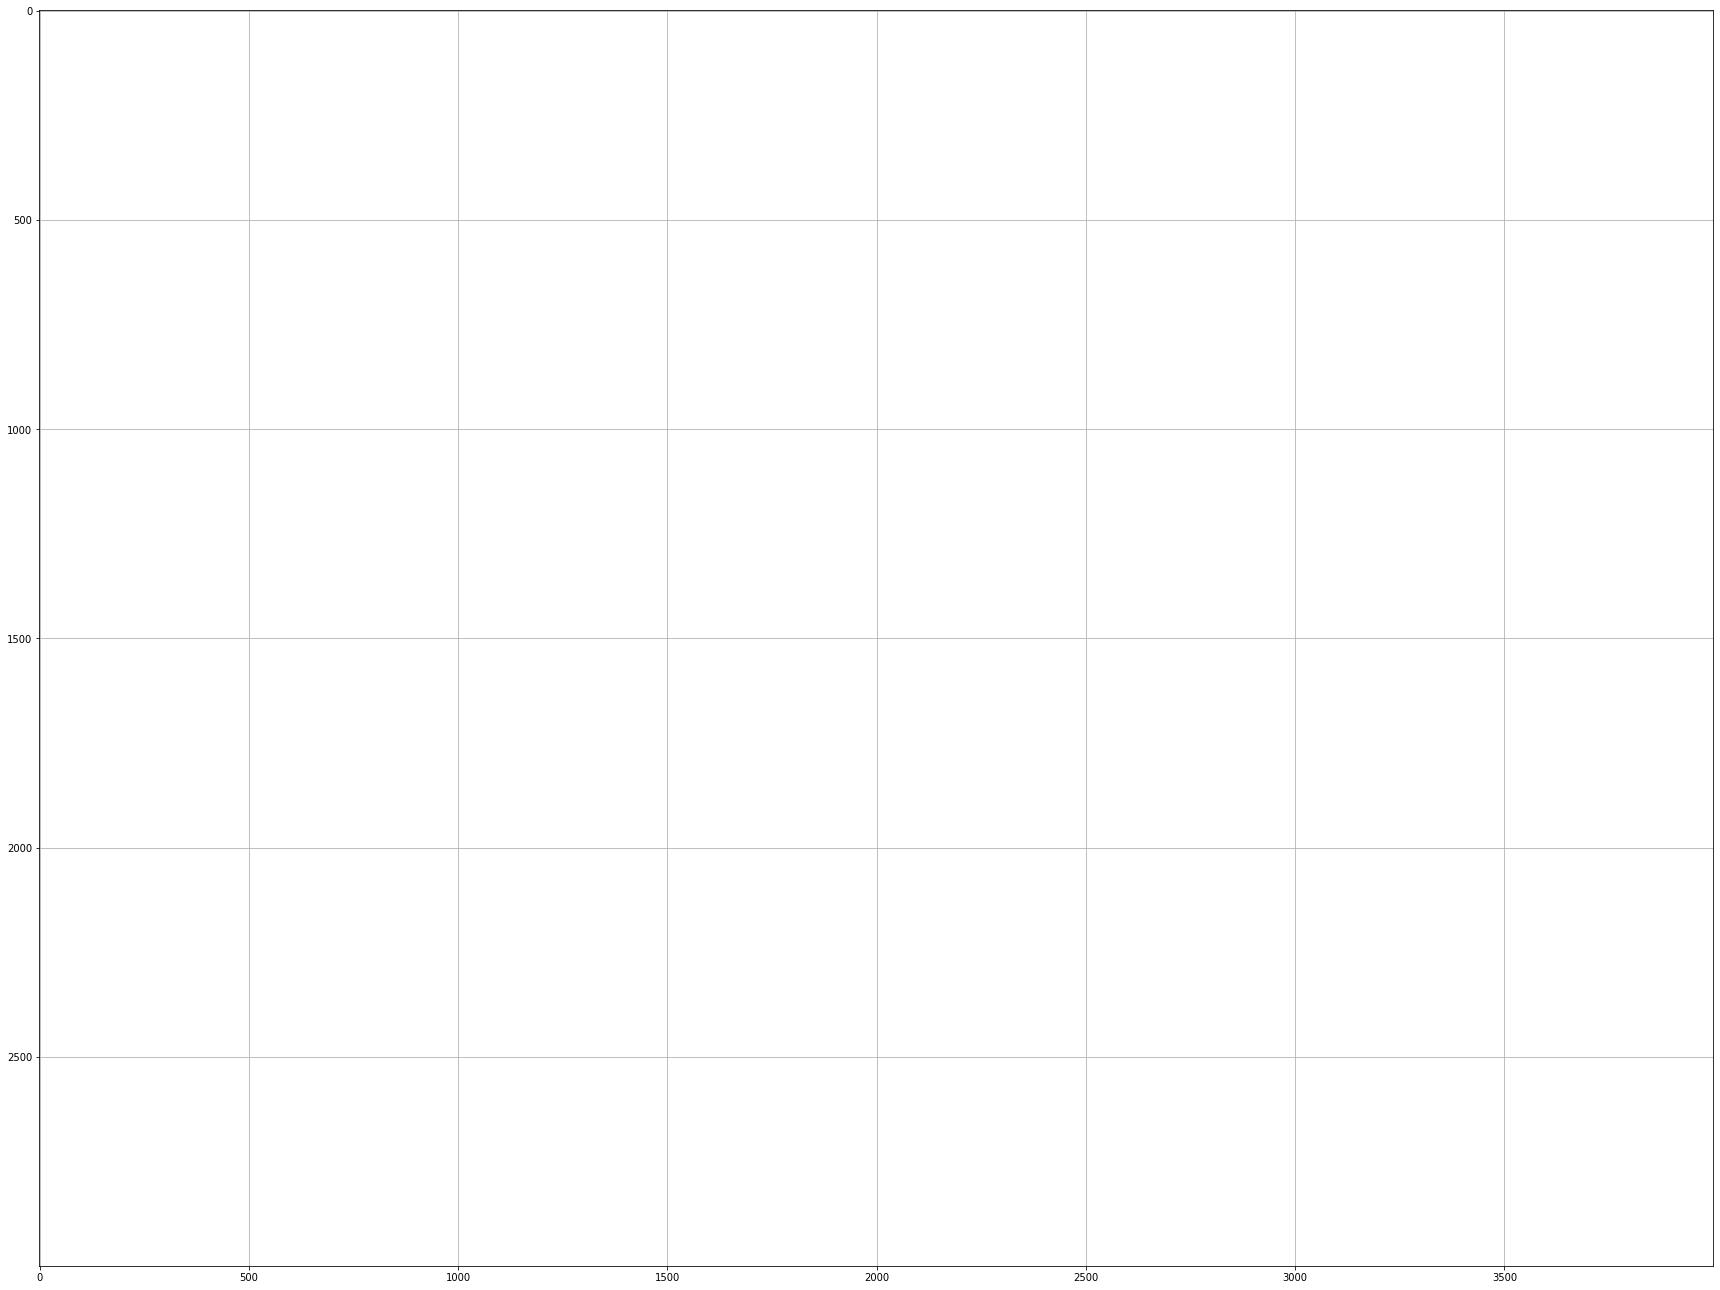

In [82]:
plt.figure(figsize = (30,25))
plt.imshow(full_image)
plt.grid(True)
plt.show()

In [79]:
# nx * ny = 1000, the number of images
nx = 50
ny = 50

# assign to grid
grid_assignment = rasterfairy.transformPointCloud2D(tsne_df__plotting[['Manifold Dim 1', 'Manifold Dim 2']].to_numpy(), target=(nx, ny))

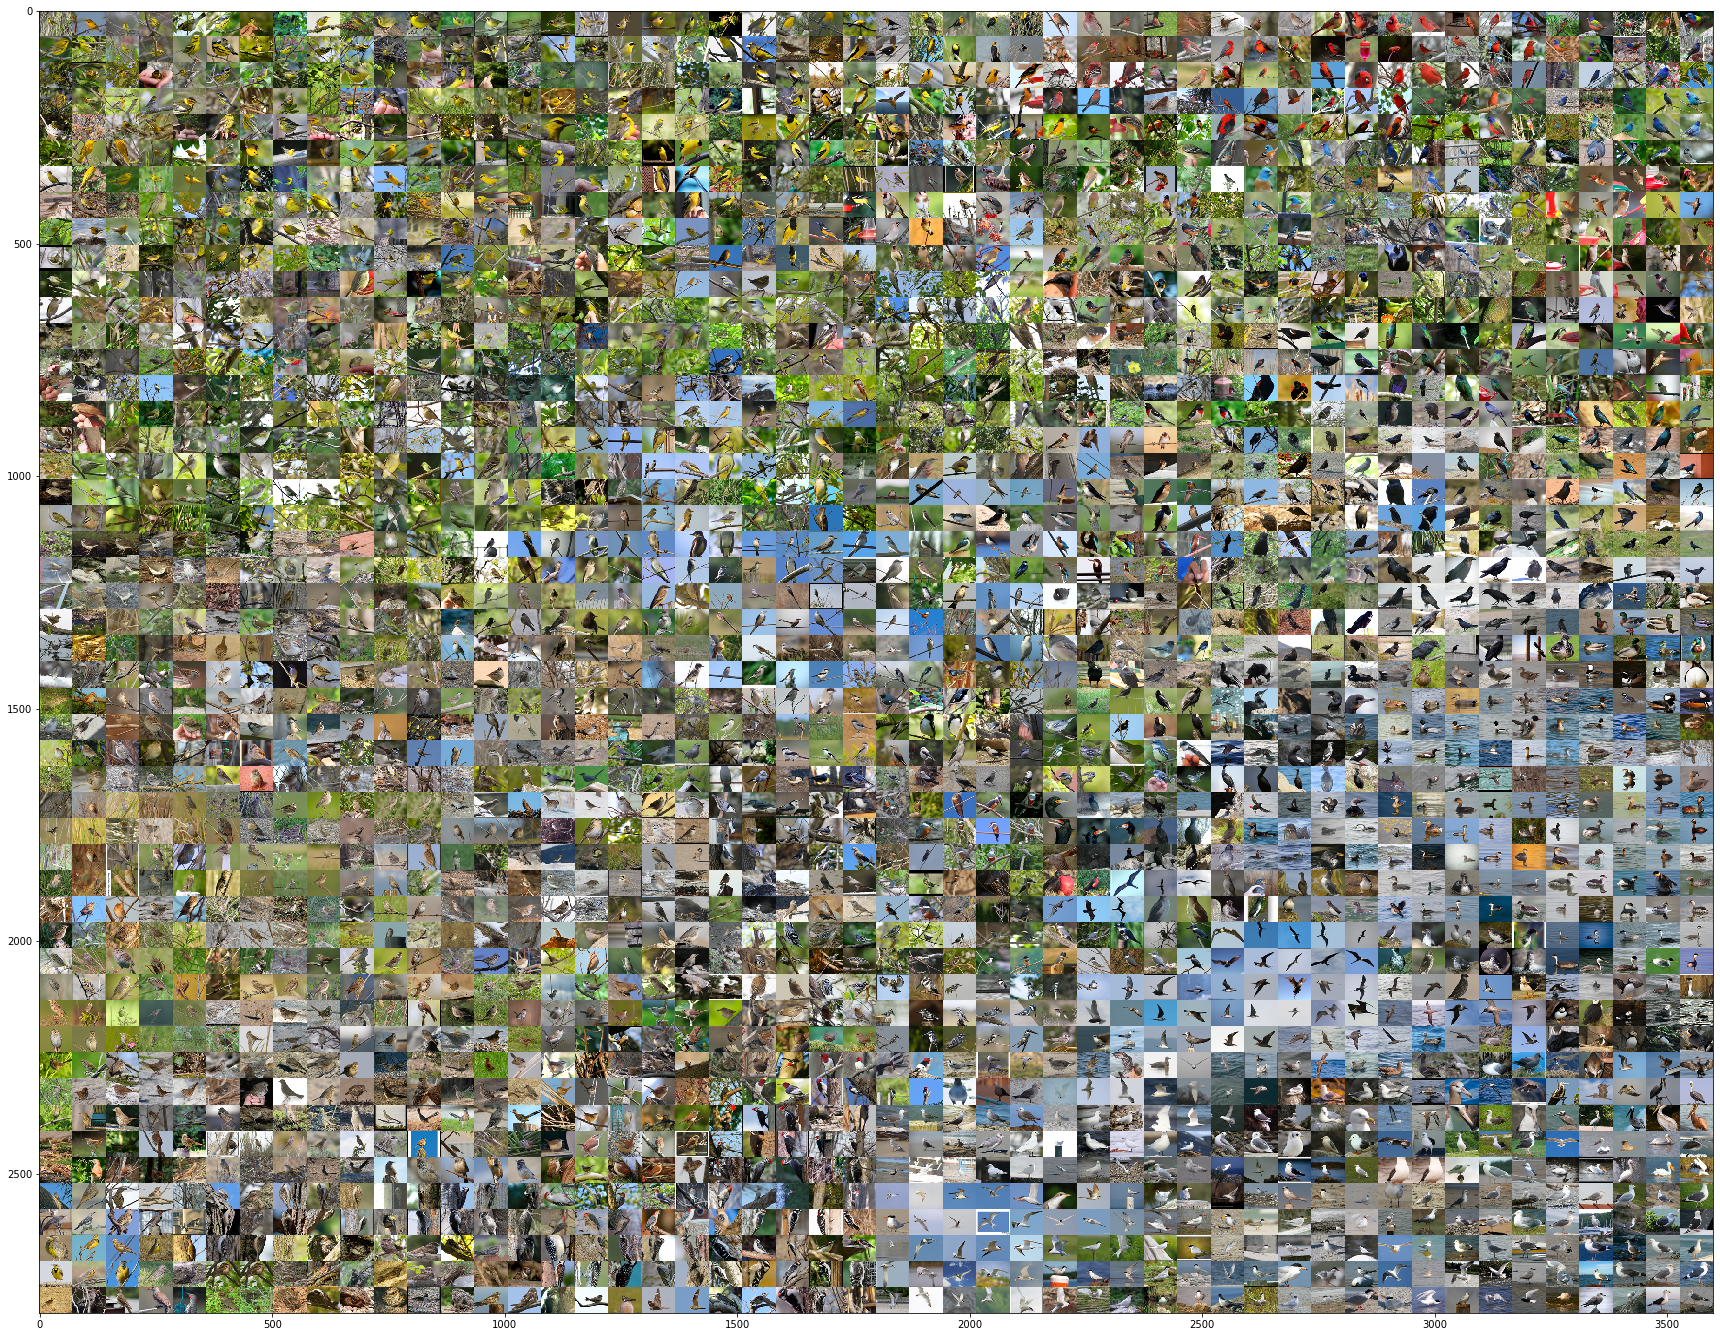

In [80]:
tile_width = 72
tile_height = 56

full_width = tile_width * nx
full_height = tile_height * ny
aspect_ratio = float(tile_width) / tile_height

grid_image = Image.new('RGB', (full_width, full_height))

for img, grid_pos in zip(tsne_df__plotting['image path'], grid_assignment[0]):
    idx_x, idx_y = grid_pos
    x, y = tile_width * idx_x, tile_height * idx_y
    tile = Image.open(img)
    tile_ar = float(tile.width) / tile.height  # center-crop the tile to match aspect_ratio
    if (tile_ar > aspect_ratio):
        margin = 0.5 * (tile.width - aspect_ratio * tile.height)
        tile = tile.crop((margin, 0, margin + aspect_ratio * tile.height, tile.height))
    else:
        margin = 0.5 * (tile.height - float(tile.width) / aspect_ratio)
        tile = tile.crop((0, margin, tile.width, margin + float(tile.width) / aspect_ratio))
    tile = tile.resize((tile_width, tile_height), Image.ANTIALIAS)
    grid_image.paste(tile, (int(x), int(y)))

plt.figure(figsize = (30,25))
plt.imshow(grid_image)
plt.show()

## UMAP of image feature maps

In [ ]:
from umap import UMAP

In [ ]:
umap = UMAP(n_neighbors=30,
            min_dist=0.05,
            n_components=2,
            metric='euclidean')

In [ ]:
umap_features = umap.fit_transform(pca_features)
umap_df = get_manifold_df(trf_data=umap_features, labels=feature_maps_dict['labels truth'], class_names=class_names)

In [ ]:
plt.figure(figsize=(20,20))
plt.scatter(umap_features[:,0], umap_features[:,1], c=feature_maps_dict['labels truth'], cmap='gist_rainbow')
plt.colorbar()
plt.grid(True)
plt.show()

In [ ]:
umap_df.hvplot.scatter(x='Manifold Dim 1', y='Manifold Dim 2', by='label (truth)', frame_width=1000, frame_height=1000, hover_cols=['class name (truth)'], grid=True, cmap='gist_rainbow')